# 이론
신경세포(뉴런)은 다수 뉴런으로부터 정보를 전달받으며, **역치 이상의 자극**이 들어오면 전기신호를 발생시켜 다른 뉴런으로 정보를 전달한다.   
#### 퍼셉트론
실제 뉴런을 본따 다수의 입력을 받은 뒤 하나의 결과를 내는 데이터 처리 구조를 **퍼셉트론**이라고 한다.   
퍼셉트론은 입력값 x와 가중치 W의 곱을 합산한 뒤 그 값을 **비선형 함수로 변환**시켜 출력한다.   
실제 뉴런에서의 역치에 해당하는 임계치를 $\Theta$로 표현한다.   
$if \sum_i^n W_iX_i \geq \Theta \rightarrow y=1$   
$if \sum_i^n W_iX_i \leq \Theta \rightarrow y=0$   
이러한 퍼셉트론의 입력값을 취합 후 출력을 만들기 위해 사용되는 함수를 **활성 함수, activation function**라고 한다.   
- 예를 들어 로지스틱 회귀는 활성 함수가 시그모이드인 퍼셉트론이며, 소프트맥스는 활성 함수가 softmax라고 볼 수 있다.   

퍼셉트론에서 데이터가 존재하는 단계를 layer, 층이라고 하며 단 2개의 층만으로 이루어진 퍼셉트론은 **단층 퍼셉트론**이라 한다.   
입출력을 제외한 나머지 층은 hidden layer, 은닉층인데 이것이 2개 이상인 MLP는 **deep neural network, 심층 신경망**이라고 한다.   
- MLP에서 각 층의 출력값은 이전 층의 출력값들로 표현이 가능하다.   

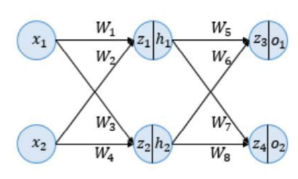   
그렇다면 이 MLP에 대해 경사하강법으로 학습을 진행시키기 위해선 어떤 과정이 필요한가?   
- o1, o2를 이용해 손실값 계산 후 W5~W8 로지스틱 회귀 학습과 유사히 업데이트가 가능할 것이다.
- 그렇다면 W1~W4는 어떻게 학습시켜야 할까?   

#### 역전파
MLP의 학습은 역전파 과정을 통해 이루어진다.   
데이터에 대한 예측값은 입력-은닉-출력 순으로 계산이 진행되지만, 반대로 가중치 학습때는 **출력층부터 가중치 업데이트가 진행**되므로 역전파라고 한다.   
미분의 연쇄법칙을 이용한다.   
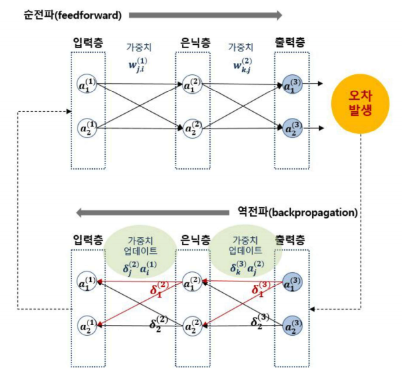   
#### 활성 함수   
인공신경망에서 활성 함수의 역할은 매우 중요하다.   
계속 써온 시그모이드 함수의 경우 고전적으로 많이 사용된 활성 함수이지만, 학습의 어려움이 존재한다.   
- 양 끝 쪽의 기울기의 절대값이 굉장히 작게 되므로, 경사하강법으로 학습시 가중치의 변화량이 매우 적어진다. 이렇게 0에 가까운 미분값들이 여러 번 곱해지면 학습 효과가 사라지는, **vanishing gradient, 기울기 소실** 현상이 발생한다.   

이를 해결가능한 간단한 활성 함수로써 ReLU 함수가 있다.   
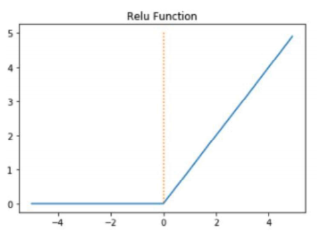   
직선의 한 군데를 꺾어서 비선형으로 만들었고, x=0에서 미분 불가능하니 실제 구현에서는 $f'(0)=0$이라고 사용한다.
#### 구현

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

nn.Sequencial은 다양한 nn.Module들을 직렬로 연결한 리스트다.   
콤마로 구분해 원하는 만큼 nn.Module들을 생성자에 넣을 수 있으며 입력한 순서대로 포워드 호출 시 각 모듈들이 실행됩니다.

In [9]:
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(784, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
training_epochs = 3
batch_size = 100

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True
                          )

mnist_test = dsets.MNIST(root='MNIST_data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True
                          )

data_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

모델이 달라져도 학습 루프는 거의 동일함을 확인할 수 있음.

In [ ]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for idx, (x_train, y_train) in enumerate(data_loader):
    x_train = x_train.view(-1, 28 * 28).to(device)
    y_train = y_train.to(device)

    outputs = model(x_train)
    cost = criterion(outputs, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

In [12]:
with torch.no_grad():
  x_test = mnist_test.data.view(-1, 28 * 28).float().to(device)
  y_test = mnist_test.targets.to(device)

  prediction = model(x_test)
  correct_prediction = torch.argmax(prediction, 1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.9624999761581421


#### 머신러닝 모델의 평가
테스트 데이터셋으로 훈련이 완료된 머신러닝 모델의 평가를 한다.   
**테스트 데이터는 절대로 학습 시에는 사용하면 안된다.** 이는 컨닝과 같다.   
- 학습을 언제 마칠 것인지 결정하거나 학습 도중 모델의 성능을 가늠해보기 위해 훈련 데이터셋 중 일부를 떼어내어 평가용으로 쓰기도 한다. 이는 **검증 데이터셋**이라고 한다.

#### 과적합   
학습 데이터셋 내의 측정오차까지 모델에 반영하여 **실제 x,y의 상관관계보다 훨씬 복잡한 관계를 표현**하게 된다. 이렇게 필요 이상으로 과하게 학습되는 현상을 **과적합**이라고 한다.
- 테스트 데이터셋은 학습 도중 활용할 수 없으므로 검증 데이터셋을 이용할 수 밖에 없다.
- 조기 종료 - 검증 데이터셋을 활용한 매우 효과적인 과적합 방지 기법   
  1. 매 epoch마다 검증 데이터셋에서 성능 측정.
  2. 성능이 최고치를 찍고 점점 안좋아지면 정해둔 epoch 수(patience) 만큼 기다림.
  3. 정해둔 수가 다하기 전에 다시 최고 성능이 개선되면 학습을 이어감.
  4. 갱신되지 않으면 학습 종료, 검증 데이터셋에서 가장 성능이 좋았던 모델 가중치를 이용해 테스트 진행.